In [ ]:
import re

# Read the input TSV file
with open("lt400.txt", "r") as infile, open("lt400.tsv", "w") as outfile:
    for line in infile:
        # Remove unwanted characters using regular expressions
        line = re.sub(r'[()]', '', line)
        #line = re.sub(r'"', '', line)
        line = re.sub(r'"', '',line)
        # Remove unwanted characters using the translate() function
        #line = line.translate({ord('('): None, ord(')'): None, ord('"'): None})

        # Replace commas with tabs
        #line = line.replace(',', '\t')

        # Write the modified line to the output TSV file
        outfile.write(line)


In [ ]:


import os
import glob
import librosa
import numpy as np
import soundfile as sf

def add_white_noise(input_filename, output_filename, desired_snr):
    # Read the input audio file
    signal, sr = librosa.load(input_filename, sr=None)

    # Remove silence from the start and end of the signal
    trimmed_signal, _ = librosa.effects.trim(signal)

    # Generate white noise
    noise = np.random.normal(0, 1, trimmed_signal.shape)

    # Calculate the signal and noise power
    signal_power = np.sum(trimmed_signal ** 2) / trimmed_signal.size
    noise_power = np.sum(noise ** 2) / noise.size

    # Calculate the scaling factor for the desired SNR level
    scaling_factor = np.sqrt((signal_power / noise_power) * 10 ** (-desired_snr / 10))

    # Scale the noise
    noise_scaled = noise * scaling_factor

    # Add the scaled white noise to the trimmed signal
    noisy_signal = trimmed_signal + noise_scaled

    # Save the modified audio signal to the output file
    sf.write(output_filename, noisy_signal, sr)

input_folder = 'lt400'
output_folder = 'output_folder'
snr_values = [-10, 0, 10, 20, 30, 40]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for desired_snr in snr_values:
    output_folder = os.path.join(output_folder, f'SNR{desired_snr}')
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for file in glob.glob(os.path.join(input_folder, '*.wav')):
        output_filename = os.path.join(output_folder, os.path.basename(file))
        add_white_noise(file, output_filename, desired_snr)






In [97]:
import os
import json
import wave
import sys
import json
from vosk import Model, KaldiRecognizer, SetLogLevel
import pandas as pd

def transcribe_files_to_tsv(input_folder):
    # Set the log level to 0 to disable debug messages
    SetLogLevel(0)

    model = Model(lang="ca")
    transcriptions = []

    # Iterate through all files in the input folder
    for file in os.listdir(input_folder):
        #print(os.path.basename(file))
        if file.endswith(".wav"):
            wf = wave.open(os.path.join(input_folder, file), "rb")
            if wf.getnchannels() != 1 or wf.getsampwidth() != 2 or wf.getcomptype() != "NONE":
                print(f"Audio file {file} must be WAV format mono PCM.")
                continue

            rec = KaldiRecognizer(model, wf.getframerate())
            rec.SetWords(True)
            rec.SetPartialWords(True)

            # Process the audio file
            last = None
            while True:
                data = wf.readframes(4000)
                if len(data) == 0:
                    break      
                if rec.AcceptWaveform(data):
                    last = rec.Result()
                else:
                    rec.PartialResult()             
                #if rec.AcceptWaveform(data):
                    
            result_json = rec.Result()
            result_dict = json.loads(result_json)
            if(result_dict["text"] == ""):
                try:
                    result_dict = json.loads(last)   
                except:
                    print("Error") 
            #results = result_dict["result"]
            #print(os.path.basename(file)+"saved")
            transcriptions.append((os.path.basename(file), result_dict["text"]))
            #print(result_dict["text"])
                    

    # Convert the list of transcriptions to a DataFrame
    transcriptions_df = pd.DataFrame(transcriptions, columns=['filename', 'transcription'])

    # Save the output to a TSV file
    transcriptions_df.to_csv("lt400.tsv", sep="\t", index=False)

input_folder = "lt400/"
transcribe_files_to_tsv(input_folder)


LOG (VoskAPI:ReadDataFiles():model.cc:213) Decoding params beam=10 max-active=3000 lattice-beam=2
LOG (VoskAPI:ReadDataFiles():model.cc:216) Silence phones 1:2:3:4:5:6:7:8:9:10
LOG (VoskAPI:RemoveOrphanNodes():nnet-nnet.cc:948) Removed 1 orphan nodes.
LOG (VoskAPI:RemoveOrphanComponents():nnet-nnet.cc:847) Removing 2 orphan components.
LOG (VoskAPI:Collapse():nnet-utils.cc:1488) Added 1 components, removed 2
LOG (VoskAPI:ReadDataFiles():model.cc:248) Loading i-vector extractor from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/ivector/final.ie
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:183) Computing derived variables for iVector extractor
LOG (VoskAPI:ComputeDerivedVars():ivector-extractor.cc:204) Done.
LOG (VoskAPI:ReadDataFiles():model.cc:282) Loading HCL and G from /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/HCLr.fst /home/lucastakanori/.cache/vosk/vosk-model-small-ca-0.4/graph/Gr.fst
LOG (VoskAPI:ReadDataFiles():model.cc:308) Loading winfo /

common_voice_ca_31378986.wav
common_voice_ca_31378986.wavsaved
per altra banda el seva seqüència numèrica no és fidel a l'ordre de composició
common_voice_ca_31340819.wav
common_voice_ca_31340819.wavsaved
el meu pare es lliuraran fabián f a b i a n
upc_ca_pau_101059.wav
upc_ca_pau_101059.wavsaved
no sé si és manca de coratge manca de personalitat o que veuen una manca de coratge i manca de personalitat els agents camp de compondre aquest triangle trinitari que té un misteri que vostè encara no ens ha resolt
common_voice_ca_31169713.wav
common_voice_ca_31169713.wavsaved
guim costa i calsamiglia és un arquitecte contemporani nascut a barcelona
common_voice_ca_30791849.wav
common_voice_ca_30791849.wavsaved
un home sosté un paraigua era una vorera molt transitada
common_voice_ca_31083166.wav
common_voice_ca_31083166.wavsaved
va editar una crisi més gran i va salvar el mercat
common_voice_ca_31792858.wav
common_voice_ca_31792858.wavsaved
a vint-i-tres de maig natural i na mireia iran al cin

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_ona_100029.wavsaved
aquesta llei contemplarà la situació de les vint-i-nou mil persones que reben pensions no contributives de jubilació o les trenta una mil persones que reben pensions no contributives d'invalidesa
common_voice_ca_30957869.wav
common_voice_ca_30957869.wavsaved
els que fem i sospita que la mà l'amor s'havia convertit en una justiciera
upc_ca_ona_100072.wav
upc_ca_ona_100072.wavsaved
i és un refugi biològic al riu tort curiosament i és un refugi biològic des de fa molts anys potser portem quinze anys o divuit anys com a refugi biològic
common_voice_ca_31063184.wav
common_voice_ca_31063184.wavsaved
en els textos el cap d'estat té de vegades amplis poders
common_voice_ca_31361137.wav
common_voice_ca_31361137.wavsaved
he d'anar del carrer del segura al carrer del mar
common_voice_ca_31147959.wav
common_voice_ca_31147959.wavsaved
dos no es barallen si un no vol
common_voice_ca_20170672.wav
common_voice_ca_20170672.wavsaved
consta de dues de planta amb molt poca alçad

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


common_voice_ca_31239888.wavsaved
també escrigué cançons música per a piano coral orquestral i per al cinema
upc_ca_pau_101010.wav
upc_ca_pau_101010.wavsaved
per tant no puc
common_voice_ca_31376532.wav
common_voice_ca_31376532.wavsaved
després d'una escala de dos dies a hawaii el demà es va dirigir cap a la costa oest
common_voice_ca_31811566.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

common_voice_ca_31811566.wavsaved
el nou d'octubre en marc i na carla aniran a pontils
upc_ca_ona_100078.wav
upc_ca_ona_100078.wavsaved
llavors vostè en dia això de molts microtalls a mi m ha semblat que amb una veu una tesi semblant al cas dels aparells de refrigeració home no és aquesta són talls
upc_ca_ona_100055.wav
upc_ca_ona_100055.wavsaved
quedo lucinat és el que ens proposen les confraries de cor això ja ho sé que és el que els proposen les confraries
common_voice_ca_31373745.wav
common_voice_ca_31373745.wavsaved
durant la seva carrera va jugar a l'arsenal el ni dels bru i alcohol city
common_voice_ca_30816585.wav
common_voice_ca_30816585.wavsaved
els homes adoni fan es van apropar els terraplens mexicans de més al sud controlats per les millors tropes de heredia
common_voice_ca_31296815.wav
common_voice_ca_31296815.wavsaved
qui organitza l de teatre dels nens
common_voice_ca_31302775.wav
common_voice_ca_31302775.wavsaved
el meu pare es diu martí pita p i té a
common_voice_ca_3

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_pau_101061.wavsaved
i precisament per aquest motiu no es podrà implantar sempre hem dit que qualsevol iniciativa que vagi encaminada a fer onejar m català o un sistema de mesurament per a les emissores catalanes
upc_ca_pau_101049.wav
upc_ca_pau_101049.wavsaved
aquest projecte d'alguna manera intentava donar resposta al que els ha expressat anteriorment separar desglossa tot el que era govern del que són estructura i funcionament
common_voice_ca_31089515.wav
common_voice_ca_31089515.wavsaved
va anar a la cova amb lenta la filla menor del seu pare adoptiu
common_voice_ca_31149064.wav
common_voice_ca_31149064.wavsaved
en són exemples el llim o l'argila
upc_ca_ona_100107.wav
upc_ca_ona_100107.wavsaved
evidentment millorant les evidentment dotant-les evidentment dotant-les en termes tecnològics i mar
common_voice_ca_30746873.wav
common_voice_ca_30746873.wavsaved
al·lel williams ha publicat un llibre titulat moldre mar màgics handbook foti camps
common_voice_ca_31135093.wav
common_voi

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

common_voice_ca_31342983.wavsaved
no ja dimorfisme sexual en el color
upc_ca_ona_100016.wav
upc_ca_ona_100016.wavsaved
vostè ens ha vingut a dir que hi ha unes grans diferències entre la uab ser i la comissió
common_voice_ca_31085491.wav
common_voice_ca_31085491.wavsaved
aquests també tenien un origen museístic
upc_ca_pau_101056.wav
upc_ca_pau_101056.wavsaved
i amb l'afany de ser breu perquè haig de ser breu la llei l'esborrany que jo he tingut a les mans i amb què ha participat en alguna sessió en un àmbit molt concret d'un subsector molt concret per a mi per una figura jurídica és surf
common_voice_ca_31434512.wav
common_voice_ca_31434512.wavsaved
diversos models dimarts s'han fet servir per crear i mag aquàrium
upc_ca_pau_101018.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_pau_101018.wavsaved
i no dubti que quan jo tingui notificació de qualsevol control intern ho torno a dir impulsats per la mateixa conselleria li ho donaré
upc_ca_pau_101054.wav
upc_ca_pau_101054.wavsaved
nosaltres en aquests moments no demanem ja protecció com demanava sempre al sector tèxtil protegir unos protegir un ús no en aquests moments no demanem protecció no la volem i ho dic en veu alta
upc_ca_pau_101014.wav
upc_ca_pau_101014.wavsaved
i estem parlant d entitats que lloguen pisos per després fer de mediadors ho estem parlant d'ajuntaments que lloguen pisos distribuïts per les ciutats per no fer guetos
common_voice_ca_31302556.wav
common_voice_ca_31302556.wavsaved
josep torredeflot i soler va ser un futbolista nascut a barcelona
common_voice_ca_31750472.wav
common_voice_ca_31750472.wavsaved
per cap d'any na carla eina sansa aniran a castellnou
upc_ca_ona_100064.wav
upc_ca_ona_100064.wavsaved
o ara aquí per exemple tenim escriptura i esborranys impresos oficials biblioteca

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


upc_ca_ona_100028.wavsaved
de conformitat amb la disposició final primera i el que estableix l'article cent onze punt ús del reglament del parlament de catalunya l'aprovació de la proposta de reforma del reglament del parlament requereix l'aprovació amb votació final per la majoria absoluta
upc_ca_ona_100059.wav
upc_ca_ona_100059.wavsaved
no sé si és manca de coratge manca de personalitat o que veuen una manca de coratge i manca de personalitat als agents que han de compondre aquest triangle trinitari que té un misteri que vostè encara no ens ha resolt
common_voice_ca_31074096.wav
common_voice_ca_31074096.wavsaved
es va traslladar a madrid de forma clandestina
upc_ca_ona_100068.wav
upc_ca_ona_100068.wavsaved
i llavors el rector així diu s'ha de dir això perquè no passi això
upc_ca_ona_100102.wav
upc_ca_ona_100102.wavsaved
el nostre grup parlamentari votarà a favor del punt un punt a i un punt bé però en canvi no podrà donar recolzament als altres tres punts
upc_ca_ona_100092.wav
upc_ca

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


upc_ca_pau_101012.wavsaved
debat i votació de la sol·licitud de compareixença del partit d'iniciativa per catalunya-verds
common_voice_ca_31173901.wav
common_voice_ca_31173901.wavsaved
john ramifica l'amarg sorprenc sentinella xiular bagenca
upc_ca_pau_101073.wav
upc_ca_pau_101073.wavsaved
mirant el futur potser corregirem allò que interessa el país i el nostre grup i el nostre govern estarà molt molt agraïts de la col·laboració que puguem rebre del seu col·legi
upc_ca_ona_100043.wav
upc_ca_ona_100043.wavsaved
però sí que demanem i ho treballarem és que la taxa aquesta taxa creada per anar a pescar per anar a fer un esport que som els únics que paguem per fer un esport
common_voice_ca_31168100.wav
common_voice_ca_31168100.wavsaved
pilar veiés i de luna és un artista nascuda a vic
common_voice_ca_31792897.wav
common_voice_ca_31792897.wavsaved
divendres el llop i na núria volen anar a bunyola
common_voice_ca_30858248.wav
common_voice_ca_30858248.wavsaved
també va donar totes les seves pr

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_ona_100061.wavsaved
i precisament per aquest motiu no es podrà implantar sempre hem dit que qualsevol iniciativa que vagi encaminada a fer onejar m català o un sistema de mesurament per les emissores catalanes
common_voice_ca_31261336.wav
common_voice_ca_31261336.wavsaved
amb la llarga caminada i ho sentia cansat aclaparat retut
common_voice_ca_31325473.wav
common_voice_ca_31325473.wavsaved
torre podrà mantenir els llaços
common_voice_ca_18489699.wav
common_voice_ca_18489699.wavsaved
des d'ahir que la tia no s'acaba de trobar bé
upc_ca_pau_101080.wav
upc_ca_pau_101080.wavsaved
de fet divendres passat vaig tornar doncs de la zona fronterera entre frança i andorra des de la zona que comprèn la carretera que va des de llúria fins a tivissa que és on s'acumulen bona part dels camps de refugiats tant a la part francesa com a la part andorrana
upc_ca_ona_100036.wav
upc_ca_ona_100036.wavsaved
digues no miri és un esquizofrènic com podria ser diabètic però no és diabètic és esquizofrèni

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


upc_ca_pau_101008.wavsaved
és a dir la primera és anem a l'emergència movem mitjans dins de l'emergència treballem dins de la vergència
upc_ca_ona_100084.wav
upc_ca_ona_100084.wavsaved
jo amb el permís dels meus companys vaig dir a l'inspector d'aquí de la via laietana que amb això no hi estaven d'acord
upc_ca_ona_100024.wav
upc_ca_ona_100024.wavsaved
s'adona que no té més temps i diu gràcies senyor president i no dóna la solució definitiva que tots esperem que sigui millor
common_voice_ca_31121143.wav
common_voice_ca_31121143.wavsaved
rocha el sis trenta-sis cinquanta-tres seixanta-vuit vuitanta-nou
common_voice_ca_31292778.wav
common_voice_ca_31292778.wavsaved
apunta la gent del número de la feia amortidor sis zero sis trenta-set seixanta-quatre cinquanta-un
upc_ca_ona_100085.wav
upc_ca_ona_100085.wavsaved
si ens presenten un document oficial conforma nosaltres autoritzem a fer la prova de la dena perquè no ens presenten un document oficial dient que hem fet la prova de la dena adeu 

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

common_voice_ca_31308015.wavsaved
lluís ridao i martín és un polític nascut a rubi
common_voice_ca_31257236.wav
common_voice_ca_31257236.wavsaved
venceslau va ser deposat després d'un rang de tres mesos però tocar el germanastre de frederic
common_voice_ca_31192759.wav
common_voice_ca_31192759.wavsaved
va ser nominada a l'ós d'or del festival internacional de cinema de berlín
common_voice_ca_31497486.wav
common_voice_ca_31497486.wavsaved
vicenç miquel pous va ser un pintor nascut a sabadell
upc_ca_pau_101074.wav
upc_ca_pau_101074.wavsaved
ara deixin dir-li dues coses de gran discrepància entre vostès i nosaltres dues només dues de les moltes més que hi podria haver però només dues molt importants
common_voice_ca_31634015.wav
common_voice_ca_31634015.wavsaved
alfonso docent il·lusa és un polític nascut a barcelona
upc_ca_pau_101005.wav
upc_ca_pau_101005.wavsaved
jo m'atreveixo a dir que era una selecció de quotes ideològica ideologies tant el millor sentit de la paraula
upc_ca_ona_10002

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_pau_101038.wavsaved
i ves per on aquest debat polític i acadèmic i academicista del federalisme ha trobat un millor acomodament en aquesta invasió i la interferència de les noves tecnologies concretant pedaços de federalisme
upc_ca_pau_101041.wav
upc_ca_pau_101041.wavsaved
per exemple al país basc no ho d el país basc va a lleó a castella lleó
upc_ca_pau_101033.wav
upc_ca_pau_101033.wavsaved
escolti vostè diu que el mapa de recursos no valia o i tant que no valia
common_voice_ca_31319267.wav
common_voice_ca_31319267.wavsaved
per citar les seves paraules ni tan sols per a restaurar el meu rei
common_voice_ca_23925403.wav
common_voice_ca_23925403.wavsaved
el període neogen segueix el període paleogen i precedeix el període quaternari
common_voice_ca_30746866.wav
common_voice_ca_30746866.wavsaved
els sentiments es consideren apropiats si encaixen en la situació actual
upc_ca_pau_101029.wav


WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc

upc_ca_pau_101029.wavsaved
aquesta llei contemplarà la situació de les vint-i-nou mil persones que reben pensions no contributives de jubilació o les trenta una mil persones que reben pensions no contributives d'invalidesa
upc_ca_pau_101024.wav
upc_ca_pau_101024.wavsaved
s'adona que no té més temps i viu gràcies senyor president i no dóna la solució definitiva que tots esperem que sigui millor
upc_ca_pau_101035.wav
upc_ca_pau_101035.wavsaved
i sàpiga que des del meu punt de vista el que passarà serà que el proper govern al decidiran els ciutadans de catalunya les urnes i d'aquí un any i mig
common_voice_ca_30759191.wav
common_voice_ca_30759191.wavsaved
ha comprat una lliure de nous
upc_ca_pau_101015.wav
upc_ca_pau_101015.wavsaved
tot i que també de dir que som coneixedors de l'àmbit de l'espai que té i aquest centre d'assistència primària de palafrugell i probablement en podríem dir que no hi cap
common_voice_ca_30949777.wav
common_voice_ca_30949777.wavsaved
l'estació més propera és l'

WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.
WARNING (VoskAPI:OutputArcForce():word-align-lattice.cc:594) Discarding word-ids at the end of a sentence, that don't have alignments.


In [ ]:
import csv
from pathlib import Path

ORIGINAL_FOLDER = "lt400"
augmented_folder = "SNR30"

# Define the folder path where the TSV file is located
folder_path = Path(ORIGINAL_FOLDER)

# Construct the TSV file path
tsv_file_path = folder_path / "lt400.tsv"

# Read the TSV file and store its contents in a dictionary
tsv_data = {}

with open(tsv_file_path, "r") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    next(tsv_file)  # Skip header row
    for line in tsv_file:
        filename, transcription = line
        tsv_data[filename] = {
            "transcription": transcription
        }

print(tsv_data)   




In [ ]:
def replace_first_space_with_tab(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            modified_line = line.replace(' ', '\t', 1)
            outfile.write(modified_line)


input_file = 'lt400.tsv'
output_file = 'output.tsv'
replace_first_space_with_tab(input_file, output_file)



In [ ]:
def remove_first_space(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            modified_line = line[1:]
            if modified_line:
                outfile.write(modified_line + '\n')


input_file = 'lt400.tsv'
output_file = 'output.tsv'
remove_first_space(input_file, output_file)


In [ ]:
def add_wav(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            filename, ext = os.path.splitext(line.strip())
            new_filename = filename + '.wav' + ext
            outfile.write(new_filename + '\n')


add_wav('lt400.tsv', 'output.tsv')



In [ ]:
import csv
from pathlib import Path
from jiwer import wer

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer(original_data, augmented_data):
    # Calculate WER for each file
    output = {}
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            wer_score = wer(original_transcription, augmented_transcription)
            print(f"WER for file {filename}: {wer_score:.2f}")
            output[filename] = wer_score
        else:
            print(f"No augmented transcription found for file {filename}")
    return (output)

# Example usage
tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)

tsvaugmented_file_path = Path("SNR40/SNR40.tsv")
tsvaugmented_data = read_tsv_file(tsvaugmented_file_path)

print(tsv_data)
print(tsvaugmented_data)
wer = calculate_wer(tsv_data, tsvaugmented_data)
print(wer)


In [ ]:
import csv
from pathlib import Path
from jiwer import wer

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer(original_data, augmented_data):
    # Calculate WER for each file
    output = {}
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            wer_score = wer(original_transcription, augmented_transcription)
            #print(f"WER for file {filename}: {wer_score:.2f}")
            output[filename] = wer_score
        else:
            print(f"No augmented transcription found for file {filename}")

    return(output)

# Example usage
tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)

tsvaugmented_file_path = Path("SNR30/SNR30.tsv")
tsvaugmented_data = read_tsv_file(tsvaugmented_file_path)

data = calculate_wer(tsv_data, tsvaugmented_data)
print(data)


In [112]:
import csv
from pathlib import Path
from jiwer import wer
from torchmetrics.functional.audio.pesq import perceptual_evaluation_speech_quality
from scipy.io import wavfile
import warnings
from pesq import cypesq
import torch
import librosa

# Suppress the specific warning messages
warnings.filterwarnings("ignore", message="To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).")

def read_audio_file(file_path):
    data, fs = librosa.load(file_path, sr=16000)
    data = torch.tensor(data, dtype=torch.float32)
    return fs, data

def calculate_pesq(fs, ref_audio, deg_audio, mode):
    # Detach the tensors from the computation graph and move them to the CPU
    ref_audio_detached = ref_audio.detach().cpu()
    deg_audio_detached = deg_audio.detach().cpu()
    
    try:
        # Call the perceptual_evaluation_speech_quality function with PyTorch tensors
        return perceptual_evaluation_speech_quality(ref_audio_detached, deg_audio_detached, fs, mode)
    except cypesq.NoUtterancesError:
        print("No utterances detected in the input audio files.")
        return -1

def pesq_from_paths(ref_file_path, deg_file_path):
    fs_ref, ref_audio = read_audio_file(ref_file_path)
    fs_deg, deg_audio = read_audio_file(deg_file_path)
    # Ensure the sampling frequencies are the same
    assert fs_ref == fs_deg, "Sampling frequencies must be the same" + str(fs_ref) + str(fs_deg)

    # Choose the mode based on the sampling frequency
    mode = 'wb' if fs_ref == 16000 else 'nb'

    if len(ref_audio) > len(deg_audio):
        pad_length = len(ref_audio) - len(deg_audio)
        deg_audio = torch.cat([deg_audio, torch.zeros(pad_length, dtype=torch.float32)])
    elif len(ref_audio) < len(deg_audio):
        deg_audio = deg_audio[:len(ref_audio)]

    # Calculate PESQ score
    pesq_score = calculate_pesq(fs_ref, ref_audio, deg_audio, mode)
    return pesq_score

def read_tsv_file(tsv_file_path):
    # Read the TSV file and store its contents in a dictionary
    tsv_data = {}

    with open(tsv_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        next(tsv_file)  # Skip header row
        for line in tsv_file:
            if len(line) == 2:
                filename, transcription = line
                tsv_data[filename] = {
                    "transcription": transcription
                }
            else:
                print(f"Skipping line with unexpected number of values: {line}")

    return tsv_data

def calculate_wer_pesq(original_data, augmented_data, output_file_path, SNR):
    # Calculate WER and PESQ for each file
    output = []
    for filename, data in original_data.items():
        original_transcription = data["transcription"]
        if filename in augmented_data:
            augmented_transcription = augmented_data[filename]["transcription"]
            ref_file_path = f"{ORIGINAL_FOLDER}/{filename}"
            deg_file_path = f"{augmented_folder}/{filename}"
            print(ref_file_path + "  " + deg_file_path)
            try:
                wer_score = wer(original_transcription, augmented_transcription)
            except:
                wer_score = -1
            pesq_score = pesq_from_paths(ref_file_path, deg_file_path)
            output.append([filename, wer_score, str(pesq_score).replace("tensor(", "").replace(")", ""), SNR])
        else:
            print(f"No augmented transcription found for file {filename}")
    # Save the output to a TSV file
    with open(output_file_path, "w", newline="") as file:
        writer = csv.writer(file, delimiter="\t")
        writer.writerow(["Filename", "WER", "PESQ", "SNR"])
        writer.writerows(output)


ORIGINAL_FOLDER = "lt400"
augmented_folder = "SNR40"

tsvoriginal_file_path = Path("lt400/lt400.tsv")
tsv_data = read_tsv_file(tsvoriginal_file_path)


SNR40_path = Path("SNR40/SNR40.tsv")
SNR40 = read_tsv_file(SNR40_path)


output_SNR40 = Path("OUTPUT40DB.tsv")


calculate_wer_pesq(tsv_data, SNR40, output_SNR40,40)




lt400/common_voice_ca_31378986.wav  SNR40/common_voice_ca_31378986.wav
lt400/common_voice_ca_31340819.wav  SNR40/common_voice_ca_31340819.wav
lt400/upc_ca_pau_101059.wav  SNR40/upc_ca_pau_101059.wav
lt400/common_voice_ca_31169713.wav  SNR40/common_voice_ca_31169713.wav
lt400/common_voice_ca_30791849.wav  SNR40/common_voice_ca_30791849.wav
lt400/common_voice_ca_31083166.wav  SNR40/common_voice_ca_31083166.wav
lt400/common_voice_ca_31792858.wav  SNR40/common_voice_ca_31792858.wav
lt400/upc_ca_pau_101070.wav  SNR40/upc_ca_pau_101070.wav
lt400/common_voice_ca_31148020.wav  SNR40/common_voice_ca_31148020.wav
lt400/upc_ca_pau_101022.wav  SNR40/upc_ca_pau_101022.wav
lt400/common_voice_ca_31480904.wav  SNR40/common_voice_ca_31480904.wav
lt400/upc_ca_ona_100029.wav  SNR40/upc_ca_ona_100029.wav
lt400/common_voice_ca_30957869.wav  SNR40/common_voice_ca_30957869.wav
lt400/upc_ca_ona_100072.wav  SNR40/upc_ca_ona_100072.wav
lt400/common_voice_ca_31063184.wav  SNR40/common_voice_ca_31063184.wav
lt400

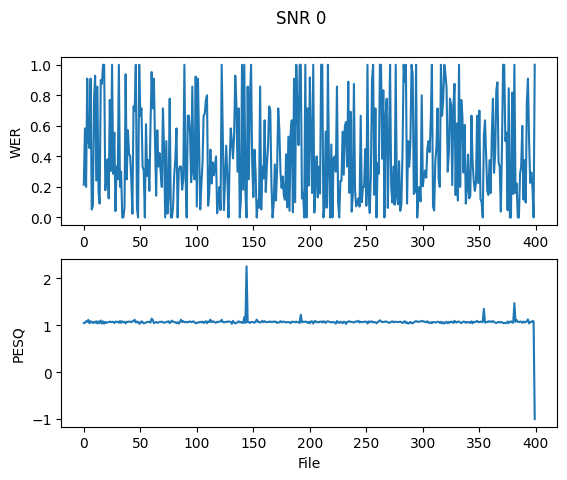

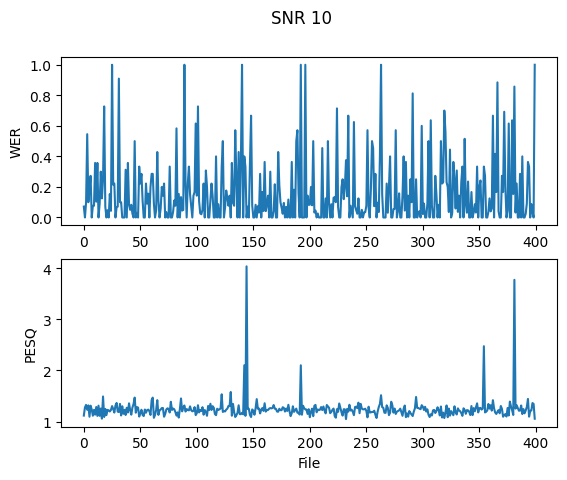

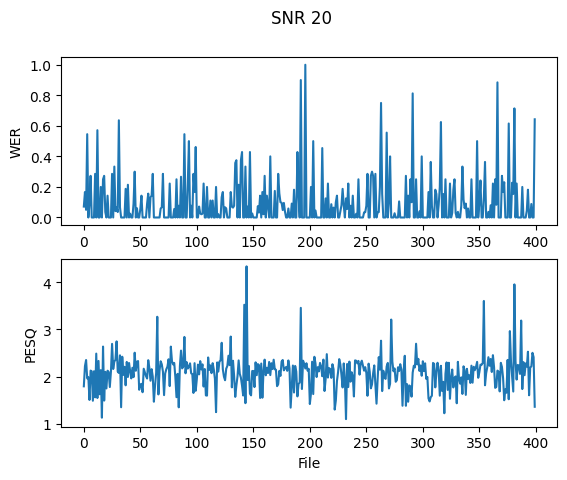

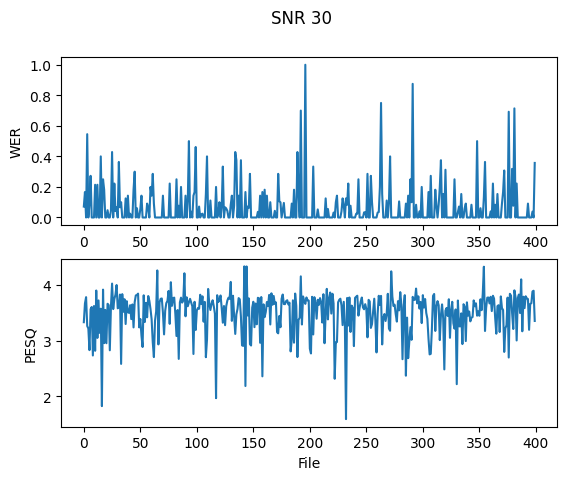

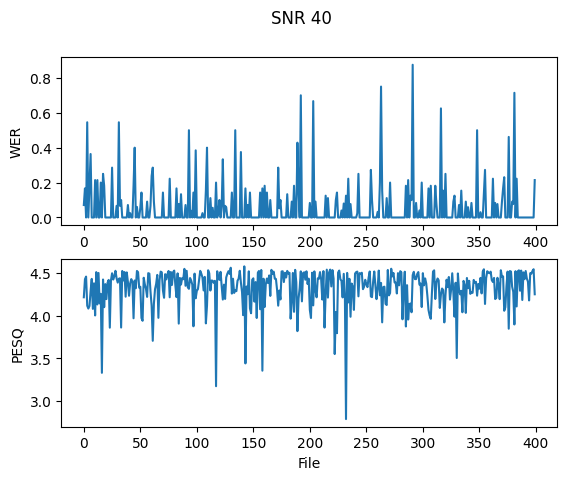

In [136]:
import csv
import matplotlib.pyplot as plt
import numpy as np

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and extract the data
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["WER"] = np.clip(data["WER"], 0,1)

    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Group the data by SNR
    grouped_data = {}
    for snr, wer, pesq in zip(data["SNR"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Plot the data for each SNR
    for snr, snr_data in grouped_data.items():
        plt.figure()
        plt.suptitle(f"SNR {snr}")
        plt.subplot(2, 1, 1)
        plt.plot(snr_data["WER"])
        plt.ylabel("WER")
        plt.subplot(2, 1, 2)
        plt.plot(snr_data["PESQ"])
        plt.xlabel("File")
        plt.ylabel("PESQ")
        plt.show()



output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


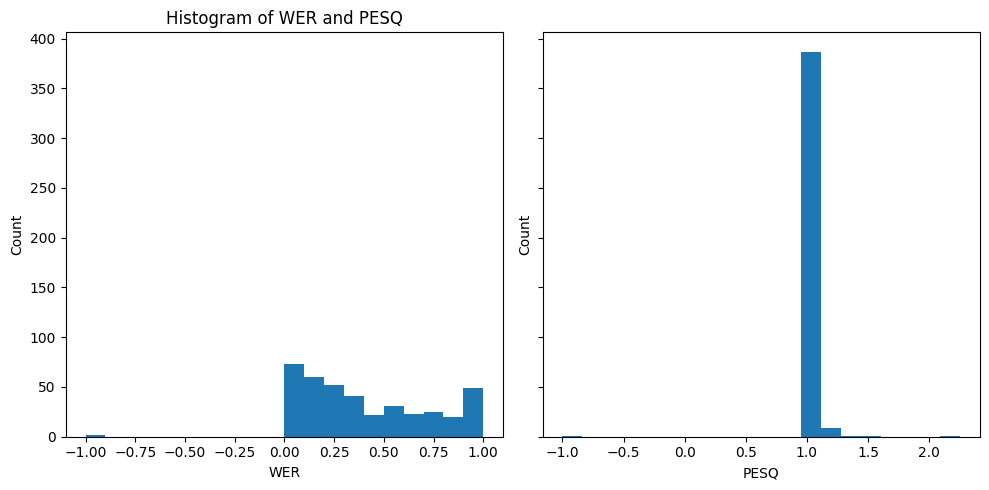

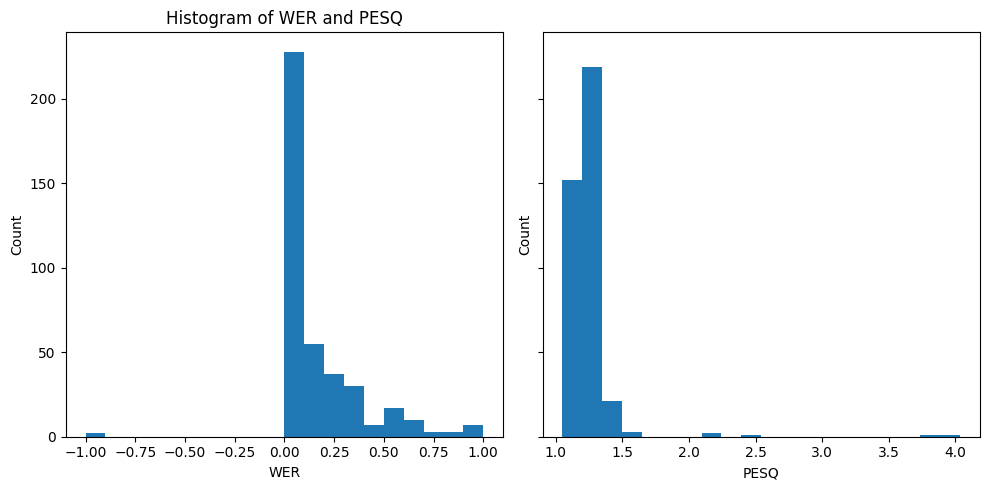

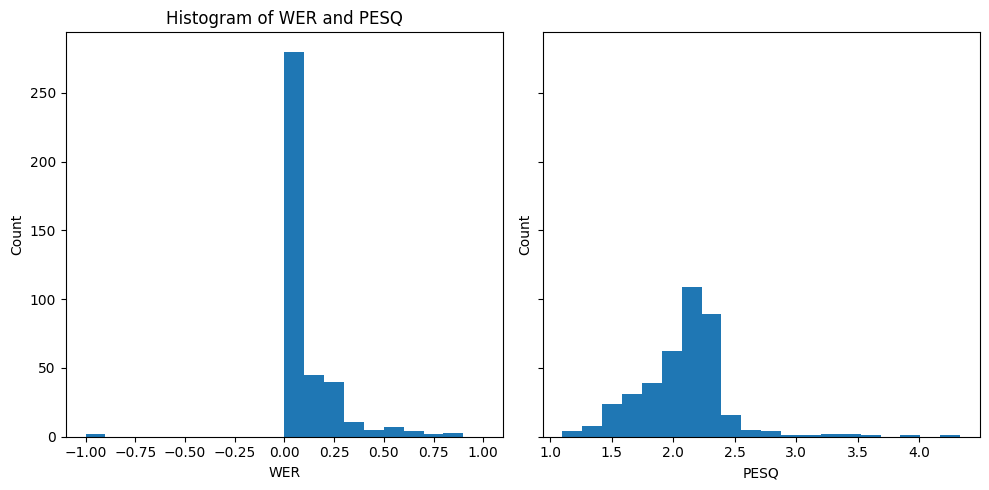

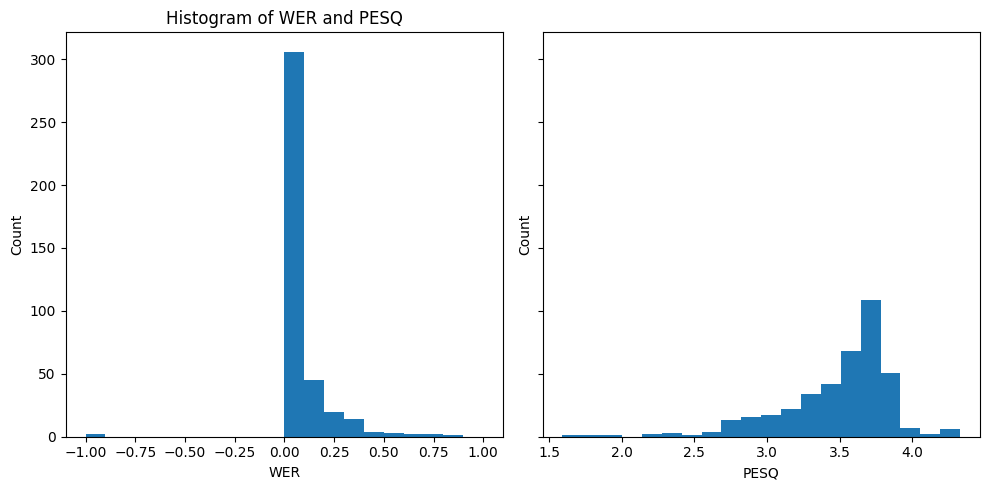

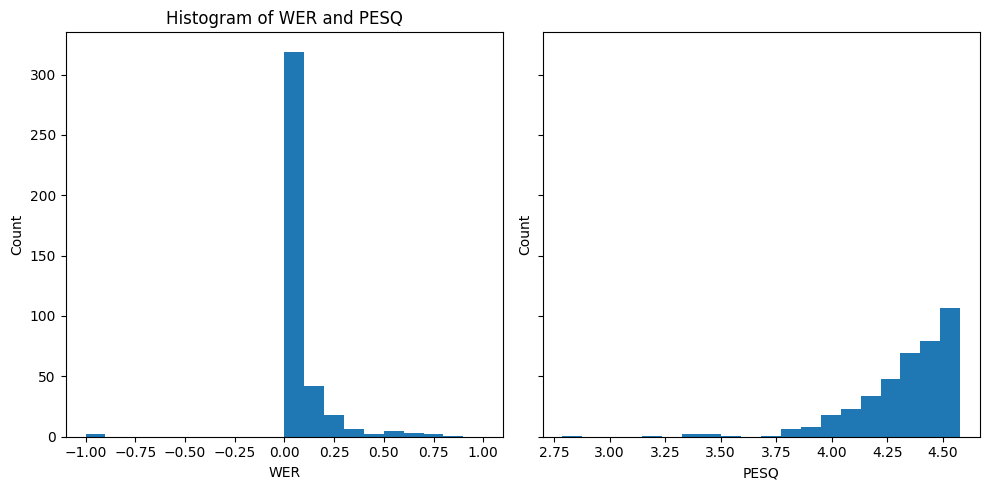

In [119]:
def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Group the data by SNR
    grouped_data = {}
    for snr, wer, pesq in zip(data["SNR"], data["WER"], data["PESQ"]):
        if snr not in grouped_data:
            grouped_data[snr] = {"WER": [], "PESQ": []}
        grouped_data[snr]["WER"].append(wer)
        grouped_data[snr]["PESQ"].append(pesq)

    # Create subplots for each SNR level
    num_snrs = len(grouped_data)
    if num_snrs == 1:
        fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_snrs, 2, figsize=(10, 10), sharey=True)

    for i, (snr, snr_data) in enumerate(grouped_data.items()):
        # Create histograms for WER and PESQ scores
        axs[i][0].hist(snr_data["WER"], range=(-1, 1), bins=20)
        axs[i][1].hist(snr_data["PESQ"], bins=20)

        # Add labels and titles
        axs[i][0].set_xlabel("WER")
        axs[i][1].set_xlabel("PESQ")
        if num_snrs == 1:
            axs[i][0].set_title("Histogram of WER and PESQ")
        else:
            axs[i][0].set_title(f"Histogram of WER (SNR {snr})")
            axs[i][1].set_title(f"Histogram of PESQ (SNR {snr})")
        axs[i][0].set_ylabel("Count")
        axs[i][1].set_ylabel("Count")

    plt.tight_layout()
    plt.show()



output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)



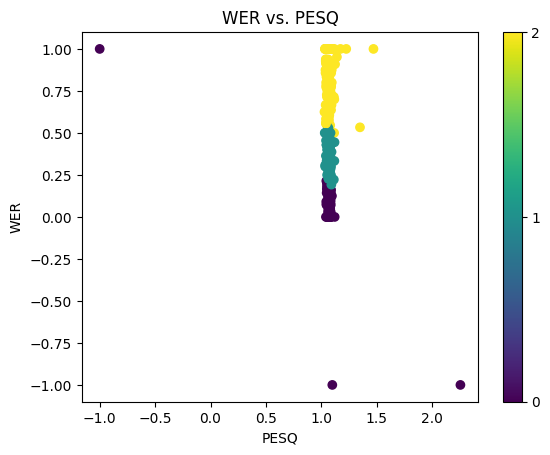

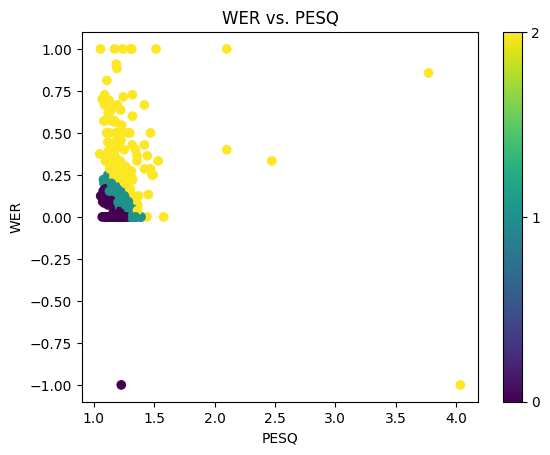

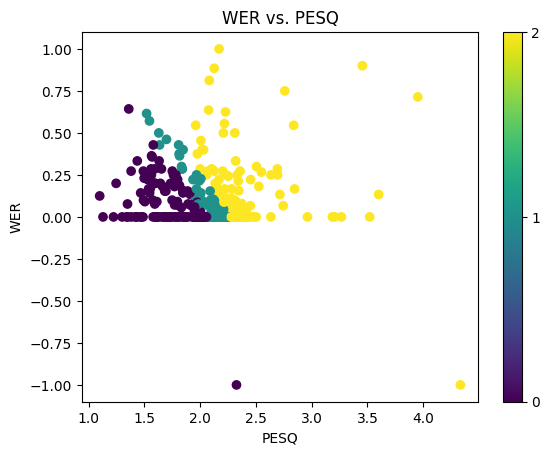

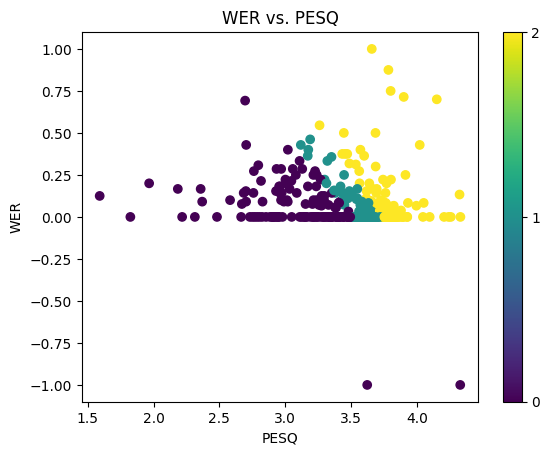

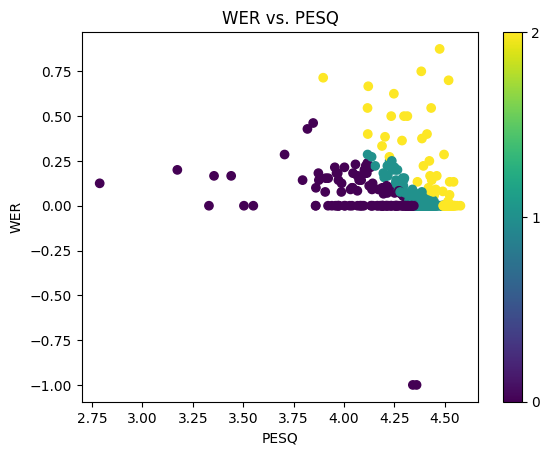

In [129]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    # Calculate combined scores and their percentiles
    combined_scores = np.array(data["WER"]) + np.array(data["PESQ"])
    combined_percentiles = np.percentile(combined_scores, [33, 66])  # [numpy.org](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)

    # Assign colors based on the percentiles of the combined scores
    colors = np.digitize(combined_scores, combined_percentiles)

    # Create scatter plot
    plt.scatter(data["PESQ"], data["WER"], c=colors)
    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.title("WER vs. PESQ")
    plt.colorbar(ticks=[0, 1, 2])
    plt.show()

output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


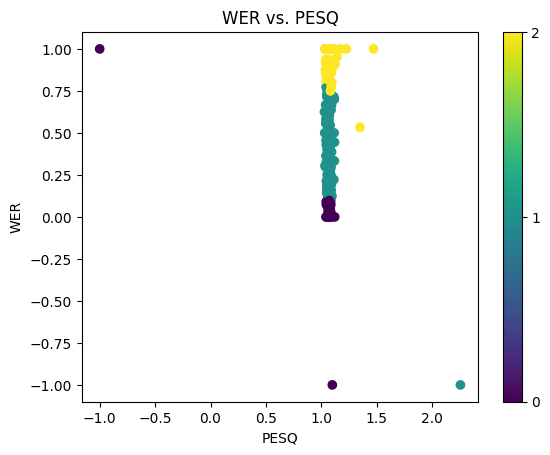

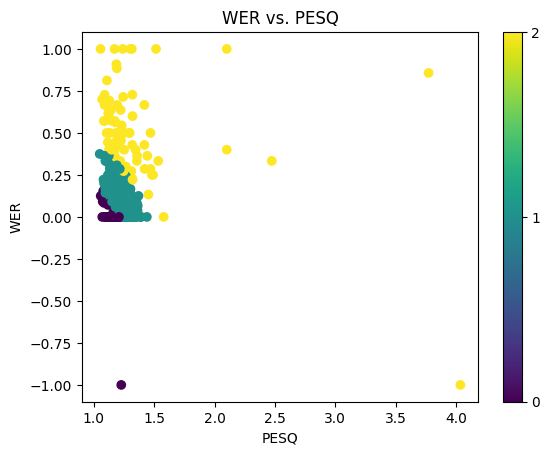

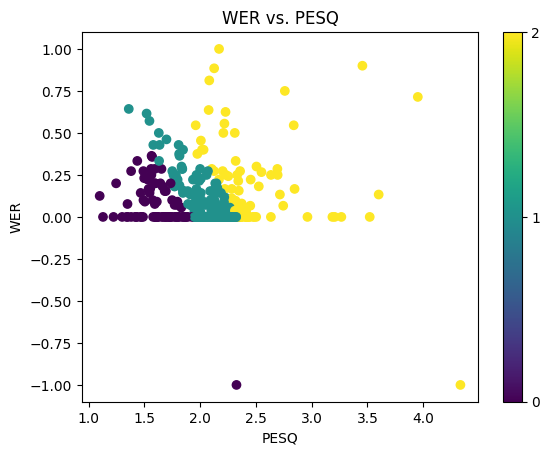

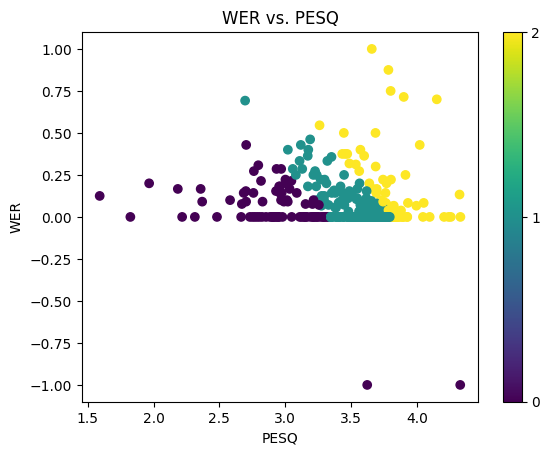

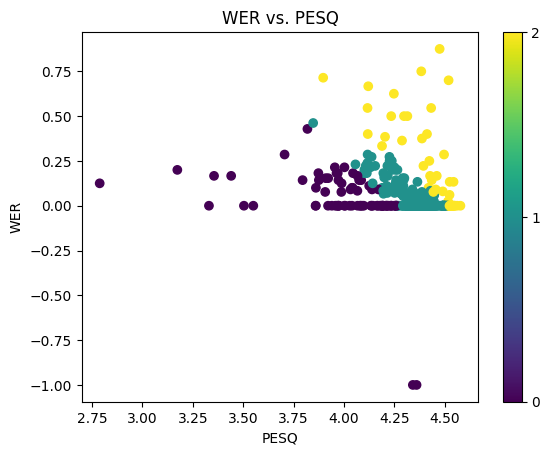

In [130]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    # Calculate combined scores and their percentiles
    combined_scores = np.array(data["WER"]) + np.array(data["PESQ"])
    combined_percentiles = np.percentile(combined_scores, [20, 80])  # [numpy.org](https://numpy.org/doc/stable/reference/generated/numpy.percentile.html)

    # Assign colors based on the percentiles of the combined scores
    colors = np.digitize(combined_scores, combined_percentiles)

    # Create scatter plot
    plt.scatter(data["PESQ"], data["WER"], c=colors)
    plt.xlabel("PESQ")
    plt.ylabel("WER")
    plt.title("WER vs. PESQ")
    plt.colorbar(ticks=[0, 1, 2])
    plt.show()

output_file_path = Path("OUTPUT0DB.tsv")
output_file_path1 = Path("OUTPUT10DB.tsv")
output_file_path2 = Path("OUTPUT20DB.tsv")
output_file_path3 = Path("OUTPUT30DB.tsv")
output_file_path4 = Path("OUTPUT40DB.tsv")

plot_wer_pesq(output_file_path)
plot_wer_pesq(output_file_path1)
plot_wer_pesq(output_file_path2)
plot_wer_pesq(output_file_path3)
plot_wer_pesq(output_file_path4)


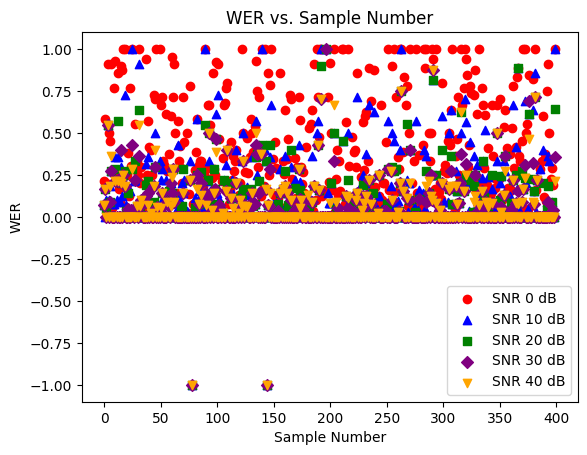

In [132]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["WER"]

# Define colors and symbols for each SNR value
snr_styles = {0: ('red', 'o'), 10: ('blue', '^'), 20: ('green', 's'), 30: ('purple', 'D'), 40: ('orange', 'v')}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

plt.figure()
for output_file_path in output_file_paths:
    snr, wer = plot_wer(output_file_path)
    unique_snr = np.unique(snr)
    for snr_value in unique_snr:
        color, marker = snr_styles[snr_value]
        mask = np.array(snr) == snr_value
        sample_numbers = np.arange(len(np.array(wer)[mask]))  # Create a range of sample numbers
        plt.scatter(sample_numbers, np.array(wer)[mask], c=color, marker=marker, label=f'SNR {snr_value} dB')

plt.xlabel("Sample Number")
plt.ylabel("WER")
plt.title("WER vs. Sample Number")
plt.legend()
plt.show()


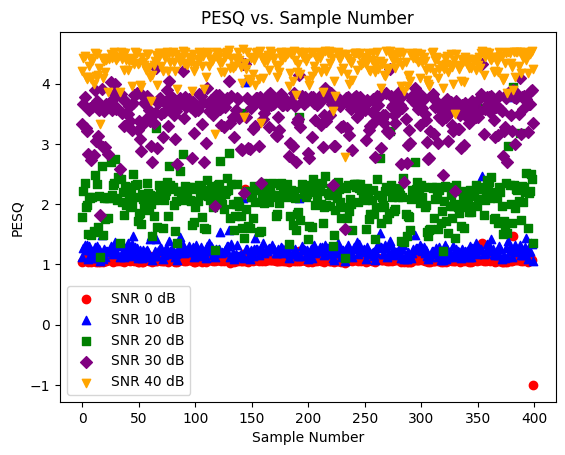

In [137]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["PESQ"]

# Define colors and symbols for each SNR value
snr_styles = {0: ('red', 'o'), 10: ('blue', '^'), 20: ('green', 's'), 30: ('purple', 'D'), 40: ('orange', 'v')}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

plt.figure()
for output_file_path in output_file_paths:
    snr, pesq = plot_pesq(output_file_path)
    unique_snr = np.unique(snr)
    for snr_value in unique_snr:
        color, marker = snr_styles[snr_value]
        mask = np.array(snr) == snr_value
        sample_numbers = np.arange(len(np.array(pesq)[mask]))  # Create a range of sample numbers
        plt.scatter(sample_numbers, np.array(pesq)[mask], c=color, marker=marker, label=f'SNR {snr_value} dB')

plt.xlabel("Sample Number")
plt.ylabel("PESQ")
plt.title("PESQ vs. Sample Number")
plt.legend()
plt.show()


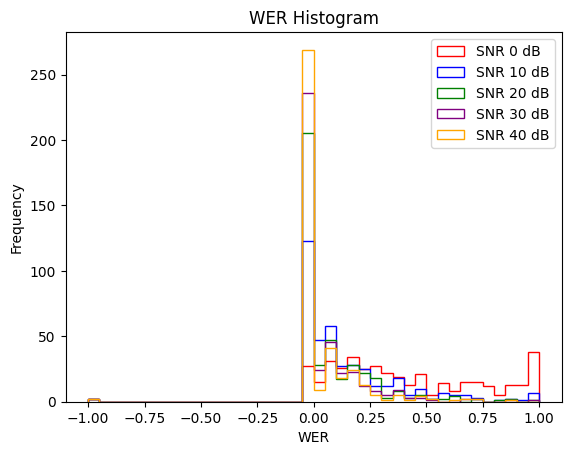

In [138]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_wer(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["WER"]

# Define colors for each SNR value
snr_colors = {0: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

wer_data = {}
for output_file_path in output_file_paths:
    snr, wer = plot_wer(output_file_path)
    for snr_value, wer_value in zip(snr, wer):
        if snr_value not in wer_data:
            wer_data[snr_value] = []
        wer_data[snr_value].append(wer_value)

plt.figure()
binwidth = 0.05
bins = np.arange(-1, 1 + binwidth, binwidth)

for snr_value, wer_values in wer_data.items():
    color = snr_colors[snr_value]
    plt.hist(wer_values, bins=bins, color=color, histtype='step', label=f'SNR {snr_value} dB')

plt.xlabel("WER")
plt.ylabel("Frequency")
plt.title("WER Histogram")
plt.legend()
plt.show()


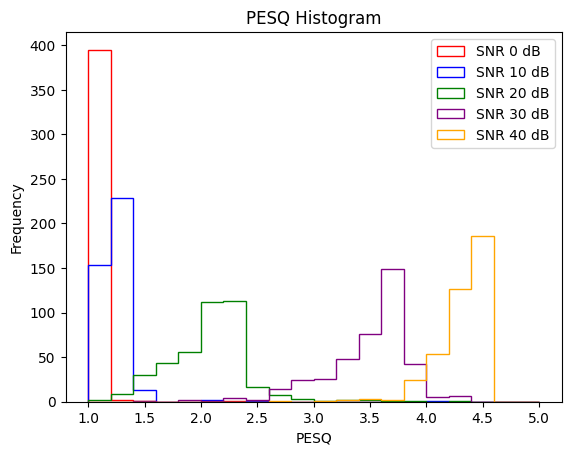

In [139]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from pathlib import Path

def plot_pesq(output_file_path):
    # Read the output TSV file and group the data by SNR
    with open(output_file_path, "r") as file:
        tsv_file = csv.reader(file, delimiter="\t")
        header = next(tsv_file)  # Skip header row
        data = {column: [] for column in header}
        for line in tsv_file:
            for column, value in zip(header, line):
                data[column].append(value)

    # Convert the data to the appropriate types
    data["WER"] = [float(wer) for wer in data["WER"]]
    data["PESQ"] = [float(pesq) for pesq in data["PESQ"]]
    data["SNR"] = [int(snr) for snr in data["SNR"]]

    # Limit WER values to be from -1 to 1
    data["WER"] = np.clip(data["WER"], -1, 1)

    return data["SNR"], data["PESQ"]

# Define colors for each SNR value
snr_colors = {0: 'red', 10: 'blue', 20: 'green', 30: 'purple', 40: 'orange'}

output_file_paths = [Path("OUTPUT0DB.tsv"), Path("OUTPUT10DB.tsv"), Path("OUTPUT20DB.tsv"),
                     Path("OUTPUT30DB.tsv"), Path("OUTPUT40DB.tsv")]

pesq_data = {}
for output_file_path in output_file_paths:
    snr, pesq = plot_pesq(output_file_path)
    for snr_value, pesq_value in zip(snr, pesq):
        if snr_value not in pesq_data:
            pesq_data[snr_value] = []
        pesq_data[snr_value].append(pesq_value)

plt.figure()
binwidth = 0.2
bins = np.arange(1, 5 + binwidth, binwidth)

for snr_value, pesq_values in pesq_data.items():
    color = snr_colors[snr_value]
    plt.hist(pesq_values, bins=bins, color=color, histtype='step', label=f'SNR {snr_value} dB')

plt.xlabel("PESQ")
plt.ylabel("Frequency")
plt.title("PESQ Histogram")
plt.legend()
plt.show()
